[![View filled on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/Sapienza-AI-Lab-a-a-2021-22/esercitazione8/blob/main/Solutions_of_ML_Classification_using_CNNs.ipynb)
[![Open filled In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Sapienza-AI-Lab-a-a-2021-22/esercitazione8/blob/main/Solutions_of_ML_Classification_using_CNNs.ipynb)


**This Exercise will help in understanding CIFAR dataset and Convolutional Neural Networks(CNN's) using the PyTorch library. We will learn how to use CNN to build a classifier to classify the image data and predict the class of the image.**

# What is CIFAR dataset?

The CIFAR-10 and CIFAR-100 are labeled subsets of the 80 million tiny images dataset. They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.

### **The CIFAR-10 dataset**

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

Here are the classes in the dataset, as well as 10 random images from each:

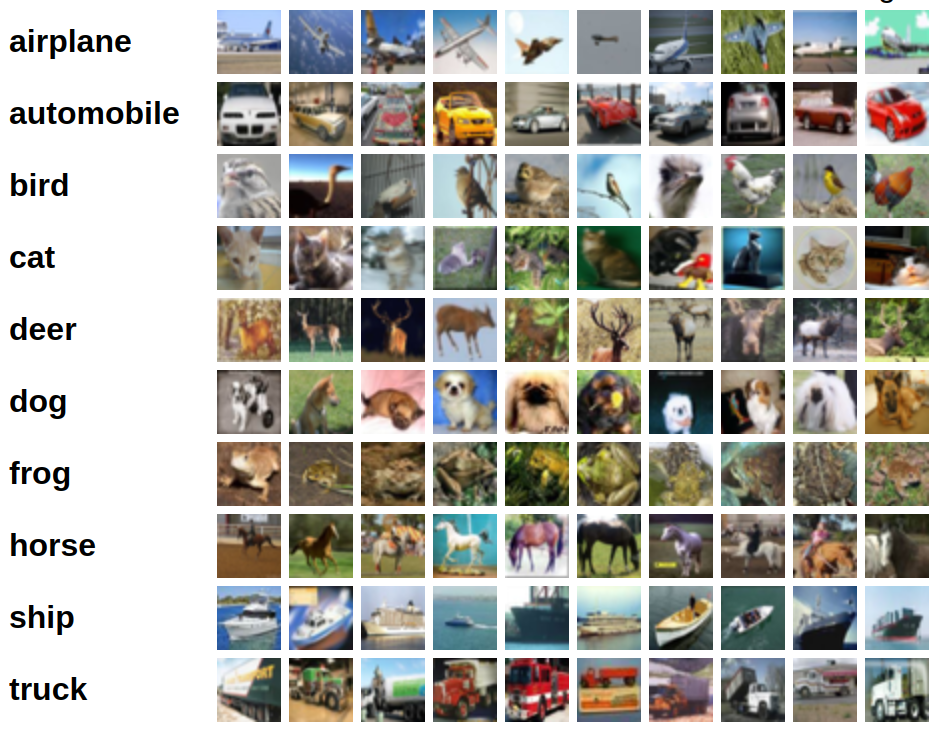

**The CIFAR-100 dataset**

This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs). You can learn more about CIFAR 100 [here](https://www.cs.toronto.edu/~kriz/cifar.html)

## Training an image classifier

You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful

Specifically for vision, there is a package called
``torchvision`` in pyTorch, that has data loaders for common datasets such as Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader`` which we have seen in the last exercise solutions.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.The images in CIFAR-10 are ofsize 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.


We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

In [ ]:
%matplotlib inline

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

### 1. Loading and normalizing CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let's see some of the training images for fun and understanding how the images are in the dataset.

truck   cat  frog  ship


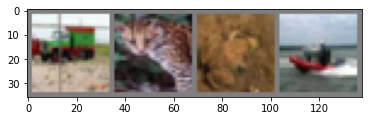

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 2. Define a Convolution Neural Network

Create the convolutional neural network from scratch to take 3-channel images (you can also use 1-channel images which will load images in grey scale as it was defined).

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = ConvNet()

### 3. Define a Loss function and optimizer
Let's use a Classification Cross-Entropy loss and SGD with momentum. you can use any other optimizer in the `optim.xxx` in Pytorch.

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

From now on things will start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.192
[1,  4000] loss: 1.930
[1,  6000] loss: 1.709
[1,  8000] loss: 1.609
[1, 10000] loss: 1.545
[1, 12000] loss: 1.481
[2,  2000] loss: 1.418
[2,  4000] loss: 1.388
[2,  6000] loss: 1.348
[2,  8000] loss: 1.313
[2, 10000] loss: 1.304
[2, 12000] loss: 1.306
Finished Training


### 5. Test the network on the test data

By Now We have trained the network for 2 passes over the training dataset.
check if the network has learnt anything at all.

Check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

GroundTruth:    cat  ship  ship plane


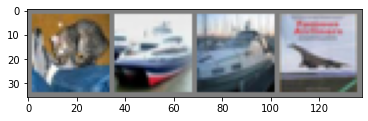

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [ ]:
outputs = net(images)

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


The results seem pretty good.

Let us check how the network performs on the whole testset.

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes). Seems like the network learnt something.

Check what are the classes that performed well, and the classes that did
not perform well:

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 68 %
Accuracy of   car : 69 %
Accuracy of  bird : 46 %
Accuracy of   cat : 46 %
Accuracy of  deer : 32 %
Accuracy of   dog : 29 %
Accuracy of  frog : 52 %
Accuracy of horse : 57 %
Accuracy of  ship : 79 %
Accuracy of truck : 51 %


### Training on pre-built networks and GPU training

How do we run these neural networks on the GPU?
Just like how you transfer a Tensor on to the GPU, you transfer the neural
net onto the GPU.

define the device as the first visible cuda device if we have CUDA available:

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

The rest of this section assumes that `device` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:


    net.to(device)


Remember that you will have to send the inputs and targets at every step
to the GPU too:


    inputs, labels = inputs.to(device), labels.to(device)

Why dont I notice MASSIVE speedup compared to CPU? Because your network
is really small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.
Try different networks (ResNet,VGG16, etc..,)

In the following code block define the network of your choice and run the other code blocks exempting the `ConvNet` we defined.

In [ ]:
# Your code class for the network of your choice goes here.

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
model.eval()

In [ ]:
#Alternate ResNet on your own

class BasicBlock(nn.Module):
  expansion = 1

  def __init__(self, in_planes, planes, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(
        in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(
        planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion * planes:
      self.shortcut = nn.Sequential(
          nn.Conv2d(
              in_planes,
              self.expansion * planes,
              kernel_size=1,
              stride=stride,
              bias=False), nn.BatchNorm2d(self.expansion * planes))

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out


class ResNet(nn.Module):

  def __init__(self, block, num_blocks, num_classes=10):
    super(ResNet, self).__init__()
    self.in_planes = 64

    self.conv1 = nn.Conv2d(
        3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
    self.linear = nn.Linear(512 * block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1] * (num_blocks - 1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes, planes, stride))
      self.in_planes = planes * block.expansion
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = torch.flatten(out, 1)
    out = self.linear(out)
    return F.log_softmax(out, dim=1)


def ResNet18():
  return ResNet(BasicBlock, [2, 2, 2, 2])

model = ResNet18()